<br />

<h1 align="center">The</h1>
<h1 align="center">Natural Language Processing</h1>
<h5 align="center">of</h5>
<h1 align="center">South Africa's State of the Nation</h1>
<h1 align="center">Addresses</h1>
<h5 align="center">by</h5>
<h3 align="center">Monde Anna</h3>

<br />
<br />


<p>Within the following notebook, we will get to explore thte priorities and challenges faced by our country over the last 23 years, that is, from the year 2000 up to and including the year 2022. Each president and as such each presidential term, will offer us insight into said priorities as well as provide a launchpad from which to gain an insight into what the core focuses of each presidential period term.</p>

<br />
<br />


<h3 align="Center">Sources</h3>

<br />

<ul>
    <br />
    <li>
        <a href="http://syllabus.africacode.net/projects/data-science-specific/natural-language-processing/">Brief</a>
    </li>
    <br />
    <li><a href="https://www.gov.za/state-nation-address">SONA Speech Archive</a>
    </li>
</ul>

<br />
<br />


<h3 align="Center">Imports</h3>

<br />
<br />


In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from string import punctuation
from datetime import datetime
from textblob import TextBlob
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import json
import nltk
import bs4
import re


<br />

<h3 align="Center">Global Settings</h3>

<br />
<br />


In [2]:
BOLD = "bold"
FIG_18_32 = 18, 32
N_COLS = 4
N_ROWS = 7
SEED = 69

sns.set(rc={
    "axes.labelpad": 12,
    "axes.labelweight": BOLD,
    "axes.titlepad": 24,
    "axes.titlesize": 18,
    "axes.titleweight": BOLD,
    "figure.figsize": (12,6),
    "figure.titlesize": 32,
    "figure.titleweight": BOLD,
})

nltk_data = [
    "averaged_perceptron_tagger",
    "omw-1.4",
    "punkt",
    "stopwords",
    "tagsets",
    "wordnet",
]

for datum in nltk_data:
    nltk.download(datum, quiet=True)


<br />

<h2 align="Center">Data Acquisition</h2>

<br />
<br />

<p>With the use of the URL addresses provided in the <i>json</i> file accompanying this project, we will scrape the State of the Nation speech archive website for each transcript of the addresses as of the year 2000. Of particular importance to us are; <b><i>Date</i></b>, the <b><i>President</i></b> making the speech and the speech's <b><i>Transcript</i></b>.</p>

<br />
<br />
<br />


In [3]:
def get_president(soup):
    """we concern ourselves with 21st century presidents"""
    presidents = {
        "Ramaphosa": "Cyril Ramaphosa",
        "Zuma": "Jacob Zuma",
        "Motlanthe": "Kgalema Motlanthe",
        "Mbeki": "Thabo Mbeki",
    }

    title = "".join(t for t in soup.find(class_="title"))

    return "".join(
        presidents[pres]
        for pres in presidents.keys()
        if pres.lower() in title.lower()
    )


In [4]:
def get_date(soup):
    str_date = soup.find(class_="field-item even").text
    return datetime.strptime(str_date, "%d %b %Y").date()


In [5]:
def get_speech(soup):
    return " ".join(
        s.text
        for s in soup.find(class_="section section-content").find_all("p")
    )


In [6]:
def get_speech_from_url(url):
    page = requests.get(url).text
    soup = bs4.BeautifulSoup(page, "html.parser")

    return {
        "president": get_president(soup),
        "date": get_date(soup),
        "speech": get_speech(soup)
    }


In [7]:
with open("../assets/speech_urls.json", "r") as file:
    speech_urls = json.load(file)


In [8]:
flattened_urls = [
    url
    for year in speech_urls
    for urls in year.values()
    for url in urls
]


<br />

<h5 align="Center">Web Scrapping</h5>

<br />

<p>Sadly, our source website is slow and at times suffers a <i>504 Gateway Time-Out</i> error. As such, the scrapped data as modelled by the <i>get_speech_from_url</i> function above has been stored using Jupyter Notebook's magic method <b><i>%store</i></b> so as to allow for quick kernel restarts.</p>

<br />
<br />


In [9]:
%%capture

%store -r scrapped_speeches

if "scrapped_speeches" not in globals():
    scrapped_speeches = [get_speech_from_url(url) for url in flattened_urls]
    %store scrapped_speeches


<br />

<h2 align="center">Text Preprocessing</h2>

<br />
<br />


<h3 align="Center">Data Cleaning</h3>

<br />

<p>In this section, we will move towards cleaning the newly acquired data. Of particular concern is ensuring that we:
    <ul>
        <li>Set all text to lowercase</li>
        <li>Prune digits</li>
        <li>Say goodbye to stop words</li>
        <li>Remove punctuation</li>
        <li>Tokenise and lemmatize the words</li>
        <li>From amongst all speeches, cull words that:
            <ol>
                <li>Occurs in the top ten list per speech, for every speech</li>
                <li>Offer little insight into the <b><i>State of the Nation</i></b>, such as remove:
                    <ul>
                        <li>Greetings</li>
                        <li>Obvious pleasantries</li>
                        <li>Titles</li>
                        <li>References to the chair of the house</li>
                        <li><i>etc...</i></li>
                    </ul>
                </li>
            </ol>
        </li>
    </ul>
</p>

<br />
<br />


In [10]:
with open("../assets/pos_wordnet_map.json", "r") as file:
    POS_MAP = json.load(file)


In [11]:
def lemmatize(speech, *, pos_map=POS_MAP):
    return [
        nltk.stem.WordNetLemmatizer().lemmatize(
            word=word,
            pos=pos_map.get(pos_tag, "n")
        )
        for word, pos_tag in nltk.pos_tag(speech)
    ]


In [12]:
def unique_word_counter(speeches):
    """ should 'speeches' be a list, then the length is found,
        elsewise, should 'speeches' be a string, said string is
        split at whitespaces, returning the element count of the
        returned collection object
    """
    return sum(
        _unique_word_counter_helper(speech)
        for speech in speeches
    )


def _unique_word_counter_helper(speech):
    if type(speech) == list:
        corrected_speech = set(speech)
    else:
        corrected_speech = set(re.split("\s", speech))
    return len(corrected_speech)


In [13]:
def deconcatinate_words(speech):
    """adds space when words have no spaces between them"""
    for match in re.findall("([a-z][A-Z])", speech):
        speech = re.sub(match, f"{match[0]} {match[1]}", speech)
    return speech


In [14]:
concat_speech = lambda speech: " ".join(speech)
remove_digits = lambda speech: re.sub("[\w|\s]*\d+[\w|\s]*", "", speech)
remove_punctuation = lambda speech: re.sub(f"[{punctuation}]+", " ", speech)
remove_stop_words = lambda speech, stop_words: [
    word for word in speech if word not in stop_words
]



<br />

<h3 align="Center">Corpus</h3>
<h5 align="Center">Initial</h5>

<br />
<br />


In [15]:
speeches = pd.DataFrame(scrapped_speeches)
speeches.set_index(keys="date", inplace=True)
speeches.head()


,president,speech
date,,
2000-02-04,Thabo Mbeki,"Madame Speaker and Deputy Speaker,Chairperson ..."
2001-02-09,Thabo Mbeki,"Madame Speaker and Deputy Speaker,Deputy Presi..."
2002-02-08,Thabo Mbeki,"Madame Speaker and Deputy Speaker,Chairperson ..."
2003-02-14,Thabo Mbeki,Madame Speaker of the National Assembly;Chairp...
2004-02-06,Thabo Mbeki,6 February 2004 Madame SpeakerChairperson of t...


<br />

<h5 align="Center">Speeches</h5>
<h5 align="Center">Add Whitespace between Individual Words</h5>

<br />
<br />

<p>As with the <a href="https://www.gov.za/node/537677">first speech of 2004</a>, often times the president begins by greeting the house. The transcript displays each greeting as a new line. Consequently, words get concatenated with no space or special character to mark where each word begins and the other ends. As luck would have it, the letter casing is left undamaged and here, we solve for this issue.</p>

<br />
<br />


In [16]:
assert "SpeakerChairperson" in speeches.speech[4]
assert "ProvincesDeputy" in speeches.speech[4]


In [17]:
word_count_prior_deconcatination = unique_word_counter(speeches.speech)
speeches.speech = speeches.speech.apply(deconcatinate_words)
word_count_post_deconcatination = unique_word_counter(speeches.speech)


In [18]:
assert "SpeakerChairperson" not in speeches.speech[4]
assert "Speaker Chairperson" in speeches.speech[4]

assert "ProvincesDeputy" not in speeches.speech[4]
assert "Provinces Deputy" in speeches.speech[4]

assert word_count_prior_deconcatination < word_count_post_deconcatination, """\
expect deconcatination to increate word count"""


<br />

<h5 align="Center">Speeches</h5>
<h5 align="Center">Set Text to Lowercase</h5>

<br />
<br />


In [19]:
speeches.speech = speeches.speech.str.lower()


<br />

<h5 align="Center">Speeches</h5>
<h5 align="Center">Remove Digits</h5>

<br />
<br />


In [20]:
speeches.speech = speeches.speech.apply(remove_digits)


<br />

<h5 align="Center">Speeches</h5>
<h5 align="Center">Removal of Punctuation</h5>

<br />
<br />


In [21]:
speeches.speech = speeches.speech.apply(remove_punctuation)


<br />

<h5 align="Center">Speeches</h5>
<h5 align="Center">Tokenize Words</h5>

<br />
<br />


In [22]:
speeches.speech = speeches.speech.apply(nltk.word_tokenize)


<br />

<h5 align="Center">Speeches</h5>
<h5 align="Center">Remove Stop Words</h5>

<br />
<br />


In [23]:
stop_words_nltk = nltk.corpus.stopwords.words("english")
stop_words_additional = ["mr", "mrs", "", " "]
stop_words = stop_words_nltk + stop_words_additional

speeches.speech = speeches.speech.apply(
    remove_stop_words, args=(stop_words,)
)


<br />

<h5 align="Center">Speeches</h5>
<h5 align="Center">Lemmatization</h5>

<br />
<br />

<p>Here we will use Part-of-Speech (POS) Tags to determine which words to apply lemmatization on. Follow the provided link for the complete <a href="https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html">Penn Treebank Project</a> list. In essence, the drive is to make words <b><i>singular</i></b> and <b><i>present tense</i></b>. A great limitation with our approach is that we mostly will garner great results with <i>ASCII</i> characters as well as have some success with <i>UTF-8</i> character sets; anything beyond, such as <a href="https://en.wikipedia.org/wiki/ISO/IEC_8859-1">ISO/IEC 8859-1</a>, may suffer as a result of this approach.</p>

<p>With great luck the prior preprocessing has left us with these variations:
    <ul>
        <li>Adjectives</li>
        <li>Adverbs</li>
        <li>Nouns</li>
        <li>Verbs</li>
    </ul>
</p>

<br />
<br />


In [24]:
assert "member" in speeches.speech[0] and "members" in speeches.speech[0]
assert "programme" in speeches.speech[0] and "programmes" in speeches.speech[0]


In [25]:
word_count_prior_lemmatization = unique_word_counter(speeches.speech)
speeches.speech = speeches.speech.apply(lemmatize).apply(lemmatize)
word_count_post_lemmatization = unique_word_counter(speeches.speech)


In [26]:
assert "members" not in speeches.speech[0]
assert "member" in speeches.speech[0]

assert "programmes" not in speeches.speech[0]
assert "programme" in speeches.speech[0]

assert word_count_post_lemmatization < word_count_prior_lemmatization, """\
expect standardisation to lemma to reduce word count"""


<br />

<h3 align="Center">Corpus</h3>
<h5 align="Center">Interim</h5>

<br />
<br />


In [27]:
speeches["tokenized"] = speeches.speech.copy(deep=True)
speeches.speech = speeches.speech.apply(
    concat_speech
)

speeches.head()


,president,speech,tokenized
date,,,
2000-02-04,Thabo Mbeki,madame speaker deputy speaker chairperson depu...,"[madame, speaker, deputy, speaker, chairperson..."
2001-02-09,Thabo Mbeki,madame speaker deputy speaker deputy president...,"[madame, speaker, deputy, speaker, deputy, pre..."
2002-02-08,Thabo Mbeki,madame speaker deputy speaker chairperson depu...,"[madame, speaker, deputy, speaker, chairperson..."
2003-02-14,Thabo Mbeki,madame speaker national assembly chairperson n...,"[madame, speaker, national, assembly, chairper..."
2004-02-06,Thabo Mbeki,general leader public service president mandel...,"[general, leader, public, service, president, ..."


<br />

<h3 align="Center">Document-Term Matrix</h3>

<br />
<br />


In [28]:
vectorizer = CountVectorizer(stop_words="english")

vector = vectorizer.fit_transform(speeches.speech).toarray()

doc_term_matrix = pd.DataFrame(
    data=vector,
    index=speeches.index,
    columns=vectorizer.get_feature_names_out(),
)

doc_term_matrix.iloc[:5, :12]


,aaron,aasroc,ab,aba,ababa,abadala,abadlwengula,abahlala,abahloniphekileyo,abakwenzayo,abalimi,abamhlophe
date,,,,,,,,,,,,
2000-02-04,0,0,1,0,0,0,0,0,0,0,0,0
2001-02-09,0,0,0,0,0,0,0,0,0,0,0,0
2002-02-08,0,0,0,0,0,0,0,0,0,0,0,0
2003-02-14,0,0,0,0,0,0,0,0,0,0,0,0
2004-02-06,0,0,0,0,0,0,0,0,0,0,0,0


<br />

<h3 align="center">Data Cleaning Cont.</h3>
<h5 align="center">Redundancies</h5>

<br />
<br />

<p>For the most part, formatting and removing none alphabetic characters looks to have been completed. To our benefit, the <i>Interim Corpus</i> offers a self-evident pattern; Thabo Mbeki tends to start his speeches in a similar way, as such we should be wary of words/phrases being repeated between documents and perhaps even within a document--yet offering little relation to any core insights that may be drawn from the speech.</p>

<p>Arbitrarily, (a) the <i>Top-Ten</i> reoccurring words between the speeches will be our target as well as (b) senseless words with regard to the core subject matter; The State of the Nation.</p>

<p>Let us attend to these matters.</p>

<br />
<br />


In [29]:
def get_redundant_words(dtm, word_finder, end_year_iloc=-1):
    this_year = dtm.index[end_year_iloc]
    
    if this_year == dtm.index[0]:
        return word_finder(dtm=dtm, year=this_year)

    return word_finder(dtm=dtm, year=this_year).intersection(
        get_redundant_words(
            dtm=dtm, 
            word_finder=word_finder,
            end_year_iloc=end_year_iloc-1
        )
    )


In [30]:
def get_set_of_words_from_current_year(dtm, year) -> set:
    used_words_mask = dtm.loc[year] > 0
    used_words = dtm.loc[year][used_words_mask].index
    return set(used_words)


In [31]:
def get_set_of_top_ten_words_for_the_year(dtm, year):
    top_ten_words = dtm.loc[year].nlargest(10).index.to_list()
    return set(top_ten_words)


<br />

<h5 align="center">Culling Top-Ten Redundancies</h5>
<h5 align="Center">Across All Speeches</h5>

<br />
<br />

</p>In plain English, we will:
    <ul>
        <li>Take the <i>Top-Ten</i> words per speech</li>
        <li>Use set intersection while recursing toward the first speech</li>
        <li>The remaining words will have logically been in the <i>Top-Ten</i> of each speech in order for said words to carry over the chained intersections</li>
    </ul>
</p>

<br />
<br />


In [32]:
assert not get_redundant_words(
    dtm=doc_term_matrix,
    word_finder=get_set_of_top_ten_words_for_the_year,
)


<br />

<h5 align="Center">Observations</h5>

<br />

<ul>
    <li>Recall, there are 27 speeches between the years 2000 and 2022, inclusive</li>
    <br />
    <li>Each year's <i>Top-Ten</i> creates the base from which to remove words that are not repeated in the list from the previous year.</li>
    <br />
    <li>One of the great benefits is that this becomes an approximately <i>O(n<sup>2</sup>)</i> operation as opposed to <i>O(n<sup>n</sup>)</i>; this occurs because each year is compared to fewer words in an established set, versus a new set.</li>
    <br />
    <li>As per the assertion above, there are no words that appear in the <i>Top-Ten</i> of each year, every year</li>
</ul>

<br />
<br />


<h5 align="center">Culling Senseless Redundancies</h5>
<h5 align="Center">Across All Speeches</h5>

<br />
<br />

</p>As far as the meaningless words:
    <ul>
        <li>We will take all words per speech</li>
        <li>Recursively cull words that do not appear in each speech</li>
        <li>Make a quick manual selection of words that we qualify as meaningless</li>
    </ul>
</p>

<br />
<br />


In [33]:
words_in_all_speeches = get_redundant_words(
    dtm=doc_term_matrix,
    word_finder=get_set_of_words_from_current_year,
)
words_in_all_speeches = sorted(words_in_all_speeches)

ncols = len(words_in_all_speeches) / N_ROWS
ncols = np.math.ceil(ncols)

while (len(words_in_all_speeches) // N_ROWS) < ncols:
    words_in_all_speeches.append("-")

words_in_all_speeches = np.array(
    words_in_all_speeches
).reshape(N_ROWS, ncols)

pd.DataFrame(
    data=words_in_all_speeches,
    index=[" "] * N_ROWS,
    columns=[" "] * ncols,
)


,,,,,,,,,,
,action,address,africa,african,area,build,business,challenge,community,continue
,country,create,development,economic,economy,education,ensure,good,government,growth
,health,high,implementation,improve,include,infrastructure,institution,issue,job,land
,lead,life,like,local,make,member,national,need,new,opportunity
,partnership,people,place,policy,president,private,programme,provide,province,public
,resource,sector,security,service,small,social,south,state,strengthen,support
,thank,time,union,woman,work,world,year,-,-,-


<br />

<h5 align="Center">Observations</h5>

<br />

<ul>
    <li><b><i>Address</i></b>, <b><i>Africa(n)</i></b>, <b><i>Country</i></b>, <b><i>National</i></b>, <b><i>President</i></b>, <b><i>South</i></b> and <b><i>Thank</i></b> all look to be fillers within the speeches</li>
    <br />
    <li>The words <b><i>Action</i></b>, <b><i>Build</i></b>, <b><i>Create</i></b> and <b><i>Make</i></b> can be said to be synonyms, as such I will be keeping <b><i>Build</i></b> as I find it easier to apply to abstract concepts such as <i>"build a sense of unity"</i> as well as more concrete concerns such as <i>"in building more concrete and sustainable sources of energy, we offer ourselves an easier time at building the wealth and prosperity of our country"</i></li>
    <br />
    <li>The words <b><i>Like</i></b> and <b><i>Year</i></b> feel as though they fell through the cracks during the initial removal of stop words</li>
</ul>

<br />
<br />


In [34]:
fillers = [
    "address",
    "africa",
    "african",
    "country",
    "national",
    "president",
    "south",
    "thank"
]

synonyms_ = [
    "action",
    "create",
    "make"
]

misc_words = ["like", "year"]

for list_ in [fillers, synonyms_, misc_words]:
    stop_words.extend(list_)


In [35]:
speeches.tokenized = speeches.tokenized.apply(
    remove_stop_words, args=(stop_words,)
)


In [36]:
dtm_len_prior_cull = doc_term_matrix.shape[1]

senseless_redundancies = [
    word
    for word in stop_words
    if word in doc_term_matrix.columns
]

doc_term_matrix.drop(columns=senseless_redundancies, inplace=True)
dtm_len_post_cull = doc_term_matrix.shape[1]

assert dtm_len_prior_cull > dtm_len_post_cull

speeches.speech = speeches.tokenized.apply(
    concat_speech
)


<br />

<h2 align="center">Data Analysis</h2>

<br />
<br />


<h3 align="Center">Descriptive Statistics</h3>

<br />
<br />


In [37]:
descriptive_stats = [
    pd.Series(
        data={
            "mode": pd.Series(speeches.tokenized[year]).mode().values[0],
            "count": pd.Series(speeches.tokenized[year]).shape[0],
            "nunique": pd.Series(speeches.tokenized[year]).nunique(),
        },
        name=year,
    )
    for year in speeches.index
]

pd.DataFrame(descriptive_stats).T.iloc[:, :11]


,2000-02-04,2001-02-09,2002-02-08,2003-02-14,2004-02-06,2004-05-21,2005-02-11,2006-02-06,2007-02-09,2008-02-08,2009-02-06
mode,government,government,government,government,people,development,government,government,improve,government,people
count,2802,2965,3716,4387,2761,1983,3545,3633,3526,3296,3451
nunique,1208,1240,1405,1502,1208,897,1353,1451,1694,1295,1474


<br />

<h5 align="Center">Observations</h5>

<br />

<ul>
    <li>The speeches look to use more words as the years go by</li>
    <br />
    <li>The number of unique words looks to be stable</li>
    <br />
    <li><b><i>Government</i></b> looks to be the primary word in most speeches with <b><i>People</i></b> and improvement-related words showing up</li>
</ul>

<br />
<br />


<h3 align="Center">Individuated Speech Complexity</h3>
<h5 align="Center">by</h5>
<h3 align="Center">President</h3>

<br />

<p>For a more fine tuned understanding of each speech, we will focus on the length and accompanying complexity of each speech pair with the speaker. Of particular concern are which president used the most unique words and which president used the most. Obviously, in order to come up with averages, we will have to take into account the number of speeches made by each.</p>

<br />
<br />


In [38]:
"""
    How do the speeches compare in terms of complexity and length?
    How many speeches are there per president?
    On average
      - which presidents use the most unique words; and
      - which presidents use the most words?
"""

"""
    Layout
      - President
      - Total N of Speeches
      - Avg. Unique Words
      - Avg. Most Words
      
    Draw conclusions from herein
"""

'\n    Layout\n      - President\n      - Total N of Speeches\n      - Avg. Unique Words\n      - Avg. Most Words\n      \n    Draw conclusions from herein\n'

<h3 align="Center">Visualise Top 5 Words</h3>
<h5 align="Center">Per Speech</h5>

<br />
<br />


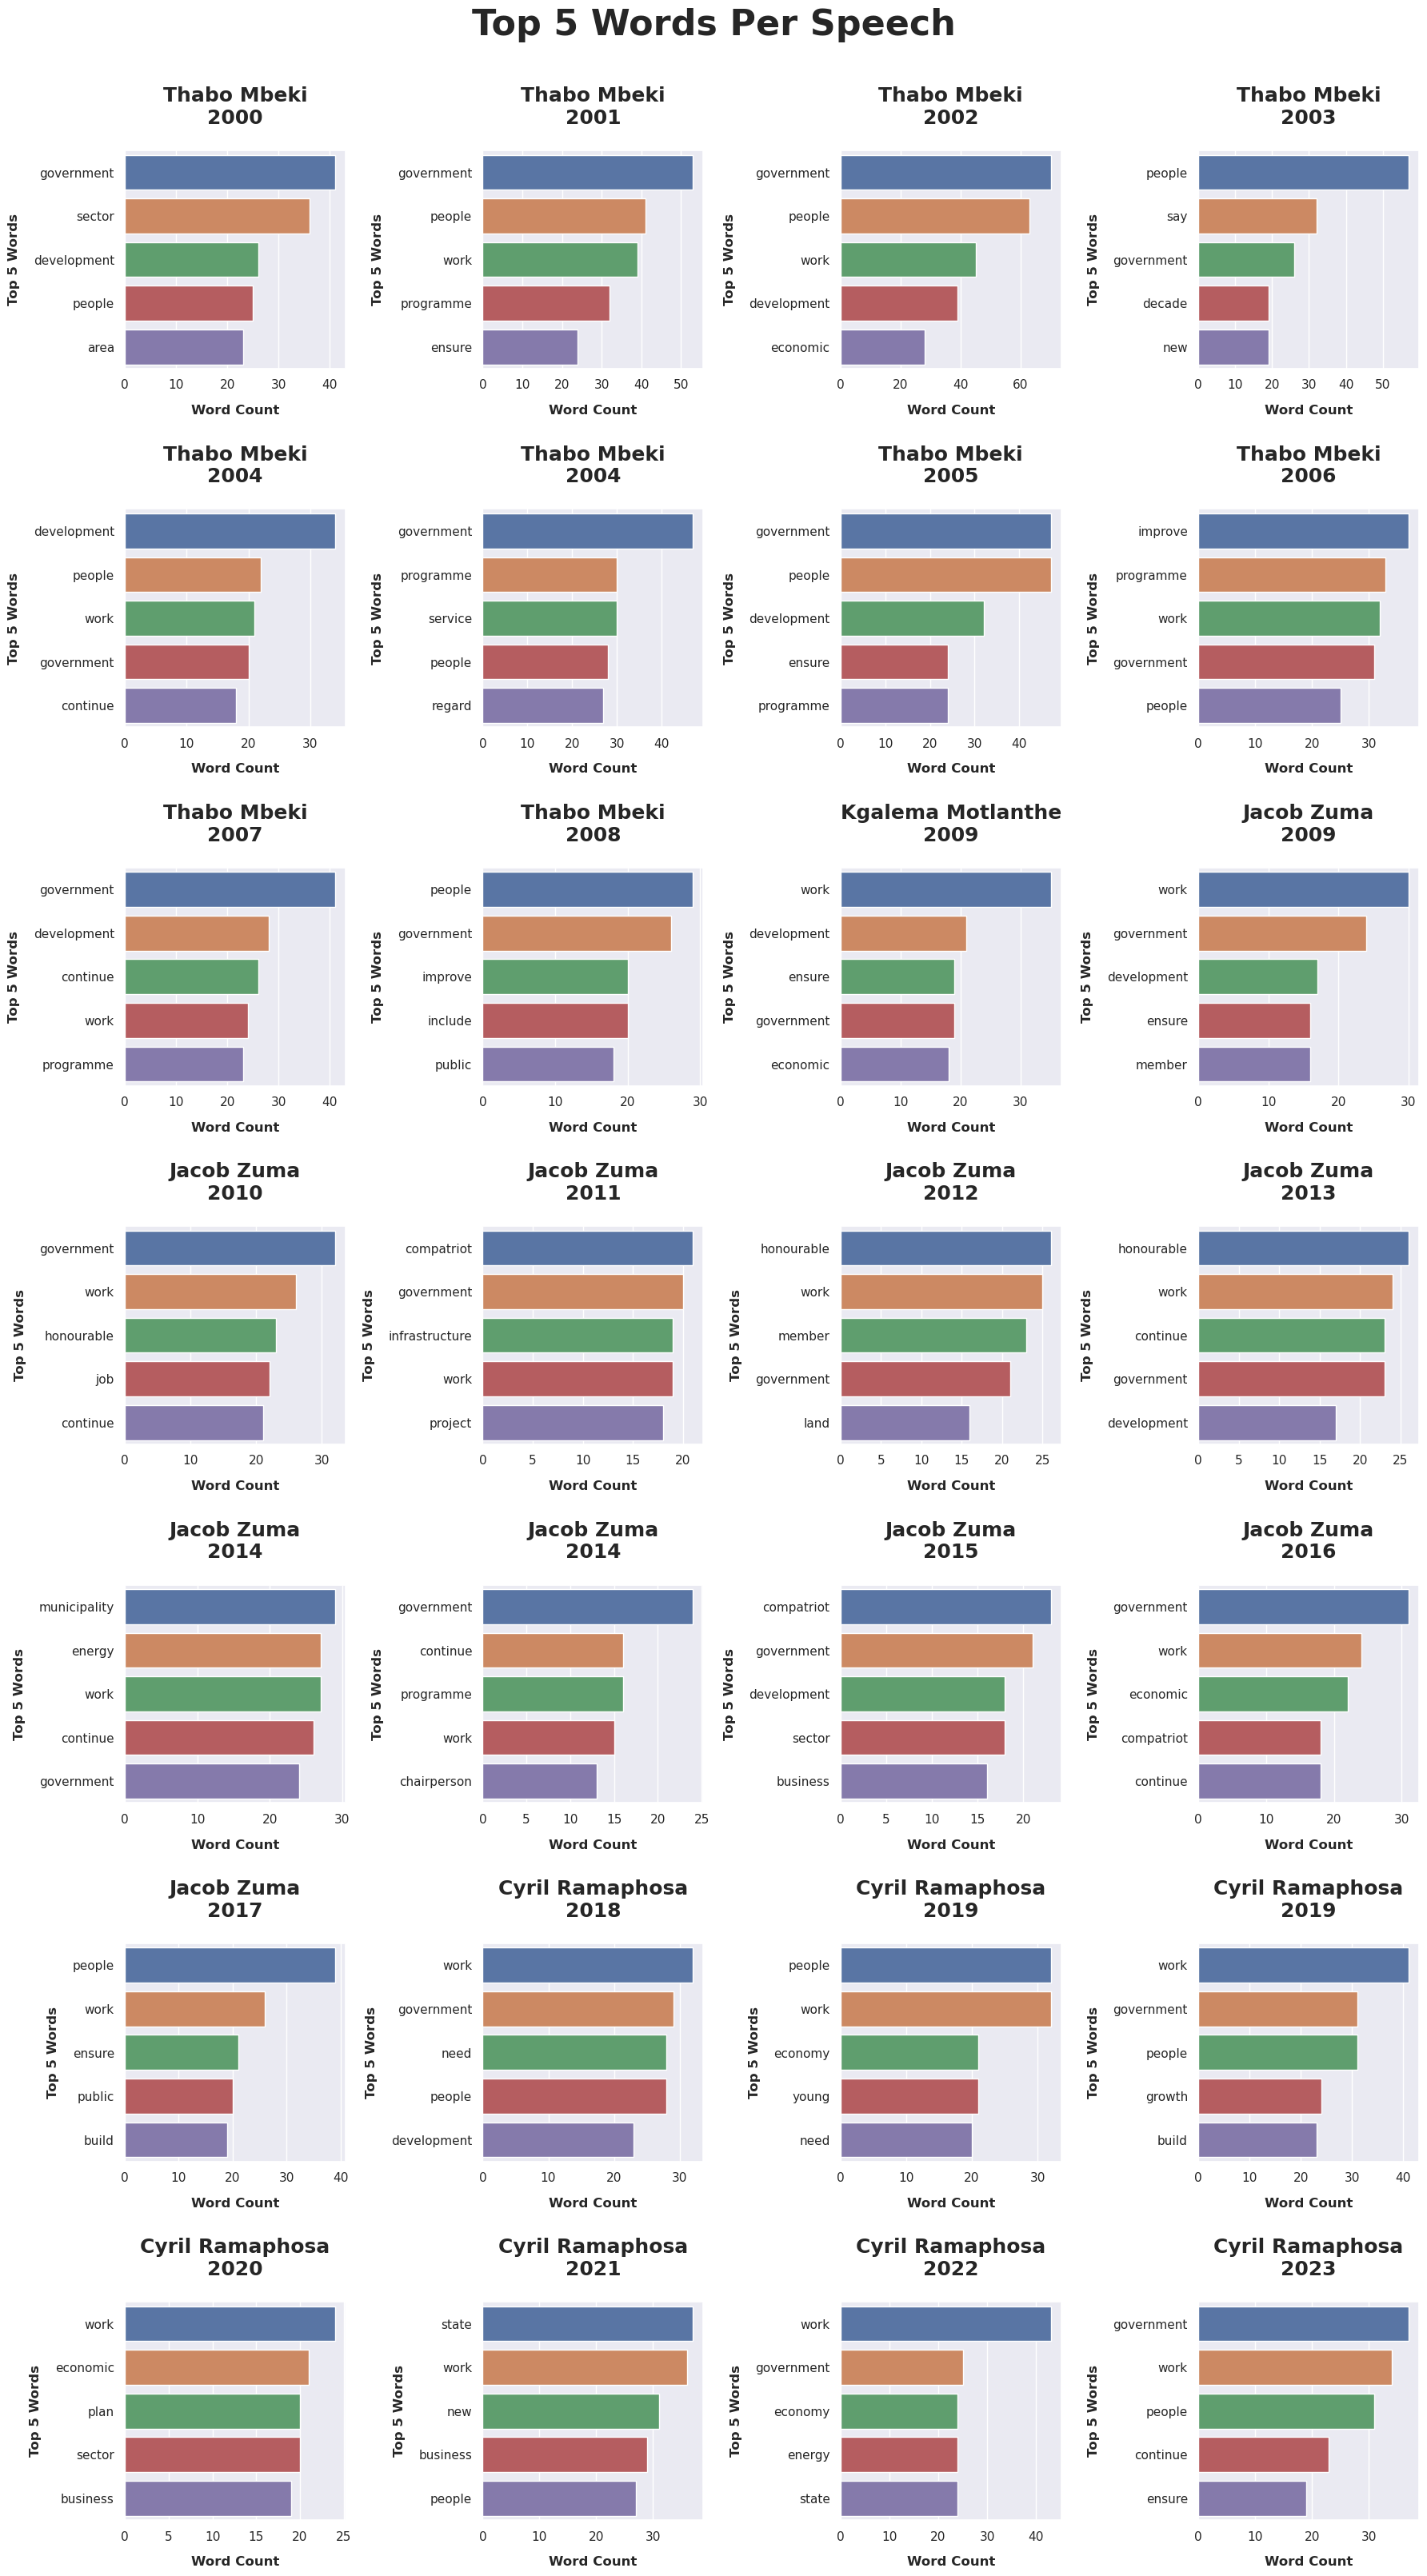

In [40]:
fig_01, _ = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=FIG_18_32)

for index, year in enumerate(doc_term_matrix.index, start=1):
    five_most_frequent = doc_term_matrix.loc[year].nlargest(5)
    sns.barplot(
        x=five_most_frequent.values,
        y=five_most_frequent.index,
    )
    
    plt.subplot(N_ROWS, N_COLS, index)

    president = speeches.loc[year].president
    plt.title(f"{president}\n{year.year}")

    plt.xlabel("Word Count")
    plt.ylabel("Top 5 Words")

fig_01.suptitle(t="Top 5 Words Per Speech", y=1.006)

plt.tight_layout(h_pad=2.125)
plt.show()


<br />

<h5 align="Center">Observations</h5>

<br />

<ul>
    <li>As evidenced above, the <b><i>Top-Five</i></b> most occurring words per year look to be sensible</li>
    <br />
    <li>Without going into too much detail, there looks to be a pattern
       arising, such as there being a constant presence of <b><i>Government</i></b>, <b><i>People</i></b> and <b><i>Work</i></b> being present in the earlier speeches</li>
    <br />
    <li>There are rather unexpected words such as <b><i>Honourable</i></b> and <b><i>Compatriot</i></b> showing up in the <b><i>Top-Five</i></b>, one wonders: Is this as a result of greeting the house or the president referring to a time of highly visible corruption?</li>
</ul>

<br />
<br />


<h3 align="Center">Word Cloud of Top 50 Words</h3>
<h5 align="Center">Per Speech</h5>

<br />
<br />


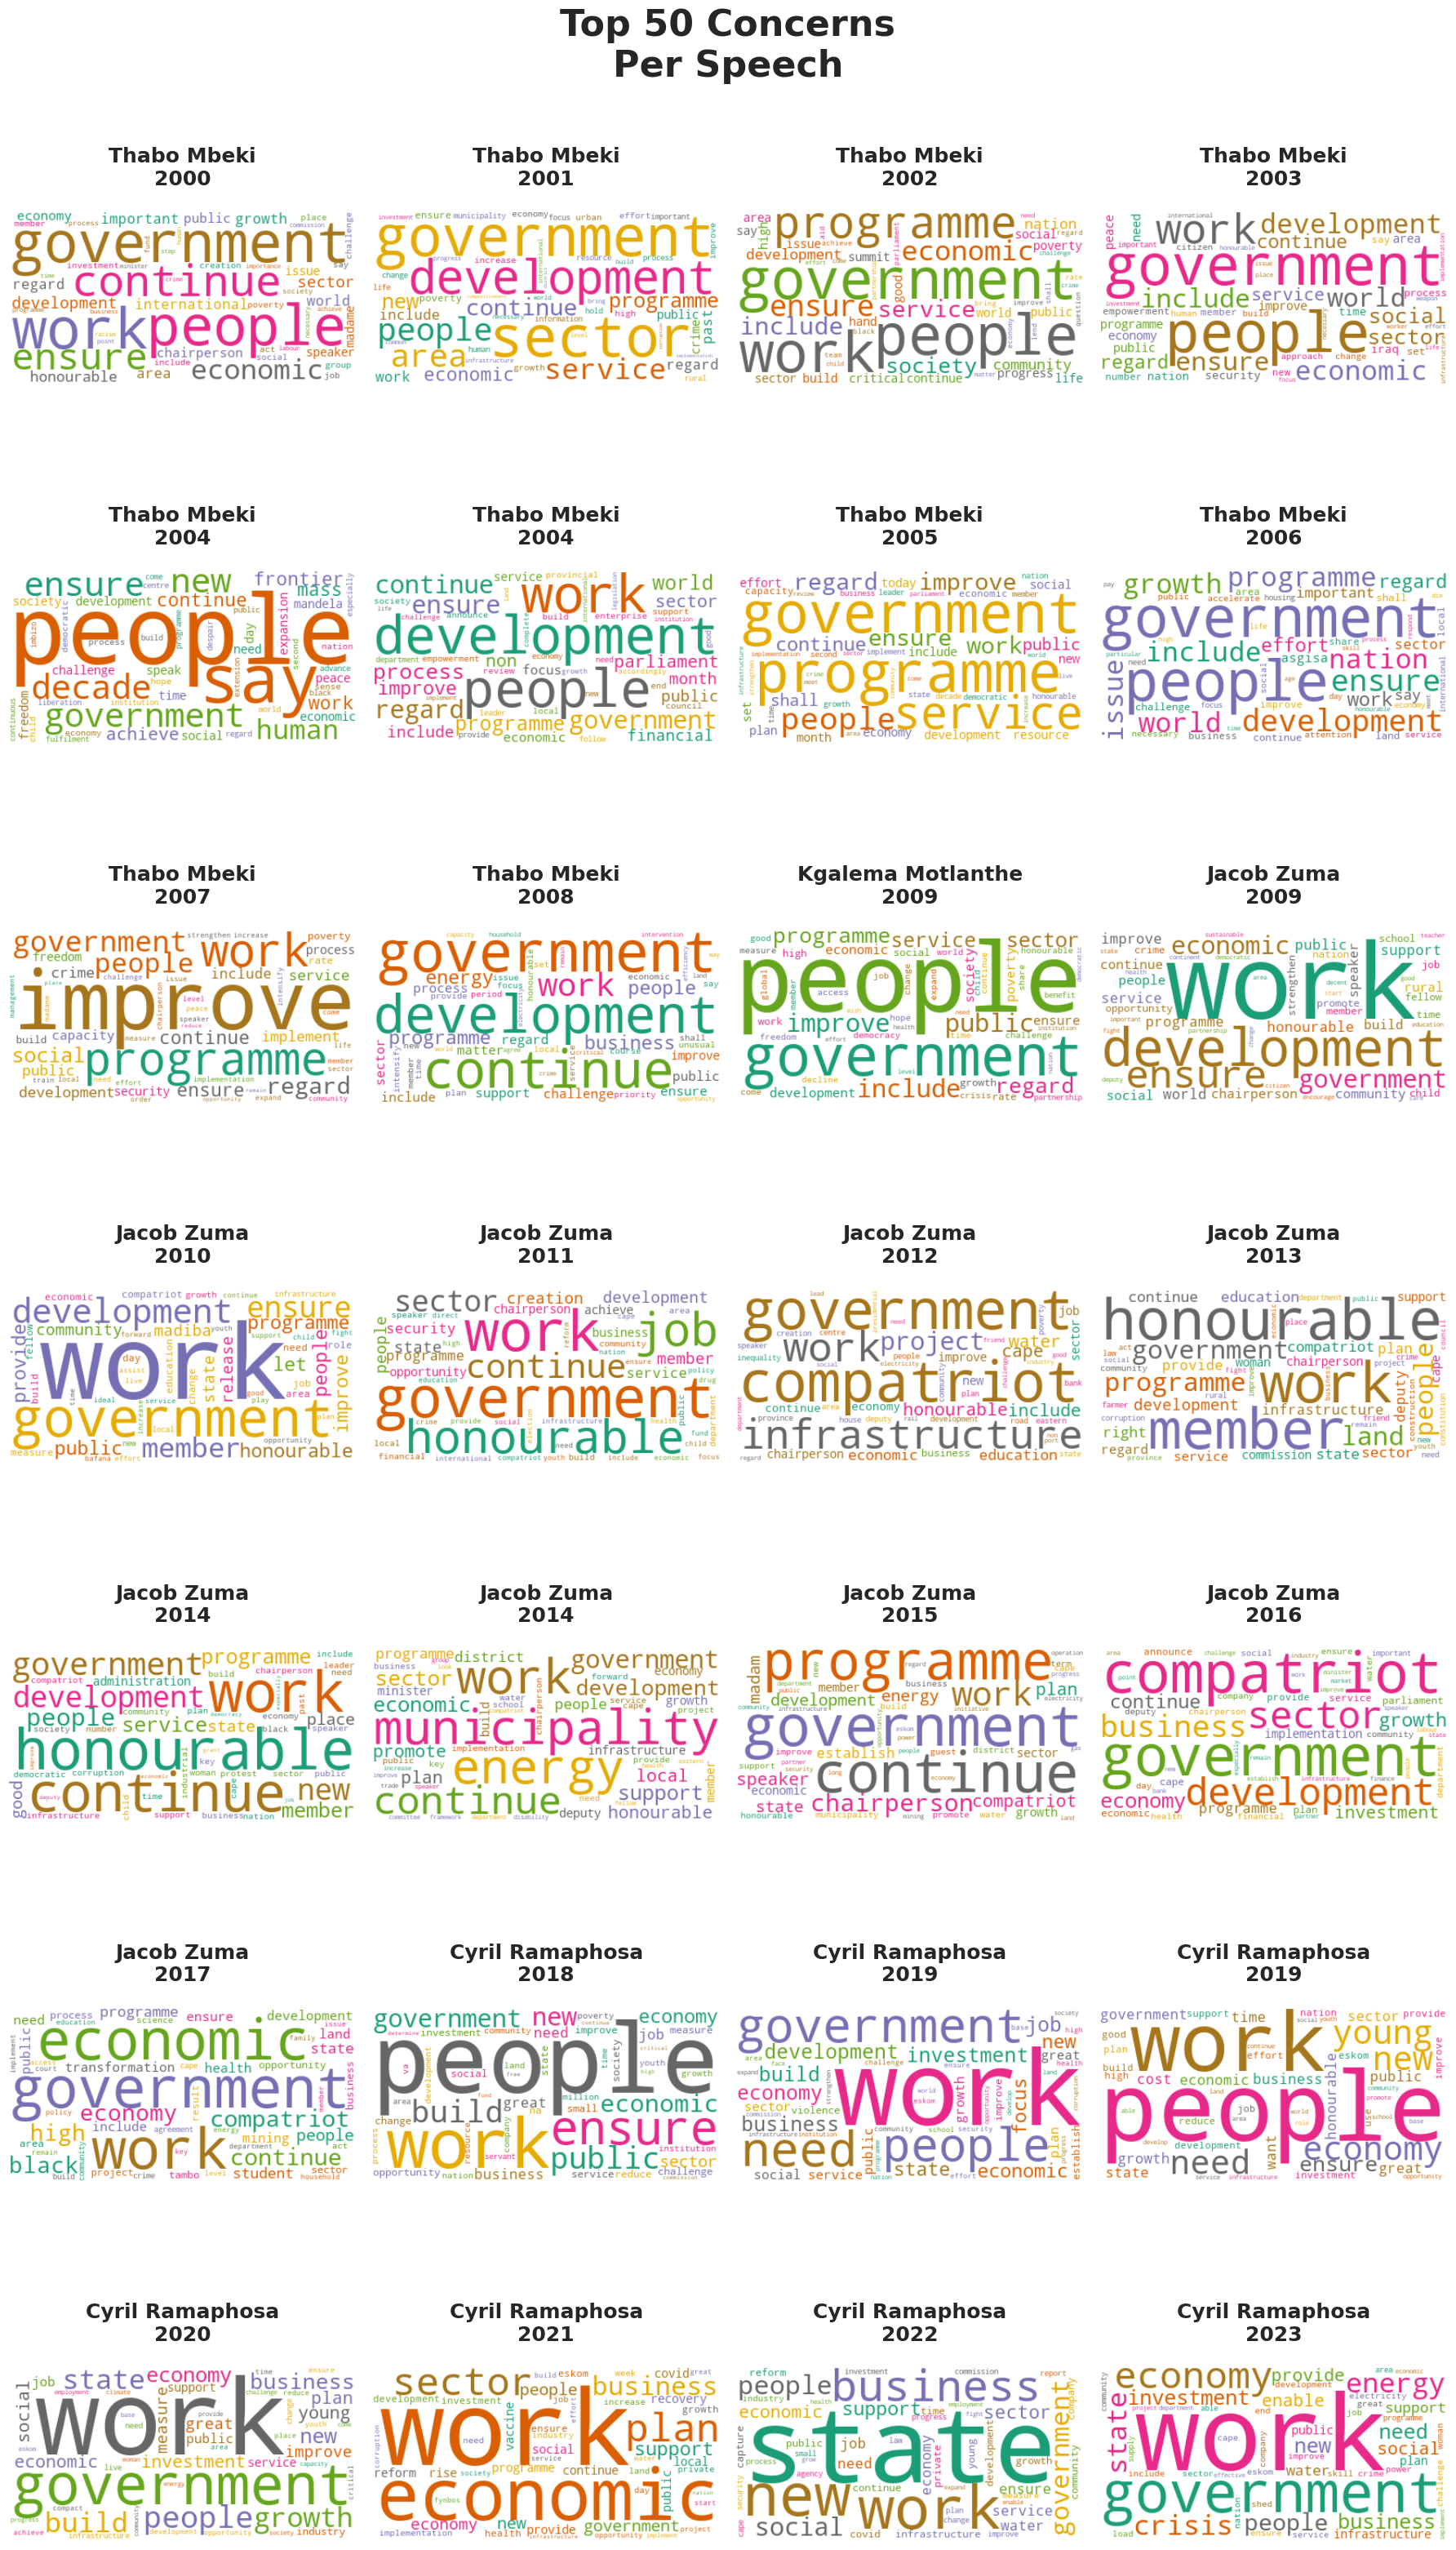

In [41]:
word_cloud = WordCloud(
    stopwords=stop_words,
    background_color="white",
    colormap="Dark2",
    max_font_size=120,
    random_state=SEED,
)

fig_02, _ = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=FIG_18_32)

for index, year in enumerate(doc_term_matrix.index, start=1):
    word_cloud.generate(
        " ".join(doc_term_matrix.loc[year].nlargest(50).index)
    )
    
    plt.subplot(N_ROWS, N_COLS, index)
    plt.axis("off")
    plt.imshow(
        X=word_cloud,
        interpolation="bilinear",
        interpolation_stage="rgba"
    )

    president = speeches.loc[year].president
    plt.title(f"{president}\n{year.year}")

fig_02.suptitle(t="Top 50 Concerns\nPer Speech", y=1.006)

plt.tight_layout(h_pad=6.125)
plt.show()


<br />

<h5 align="Center">Observations</h5>

<br />

<ul>
    <li>This follows the same pattern that the <b><i>Top-Five</i></b> words follow</li>
    <br />
    <li>Note the theme of repetitiousness; for instance, the year <b><i>2021</i></b> has <i>work</i>, <i>economic</i>, <i>sector</i>, <i>plan</i> and <i>business</i> as standout words, yet all these could be said to mean the same thing</li>
</ul>

<br />
<br />


<br />

<h3 align="center">Sentiment Analysis</h3>
<h5 align="center">Across Speeches</h5>

<br />
<br />


In [42]:
speeches["polarity"] = speeches.speech.apply(
    lambda speech: TextBlob(speech).sentiment.polarity
)

speeches["subjectivity"] = speeches.speech.apply(
    lambda words: TextBlob(words).sentiment.subjectivity
)


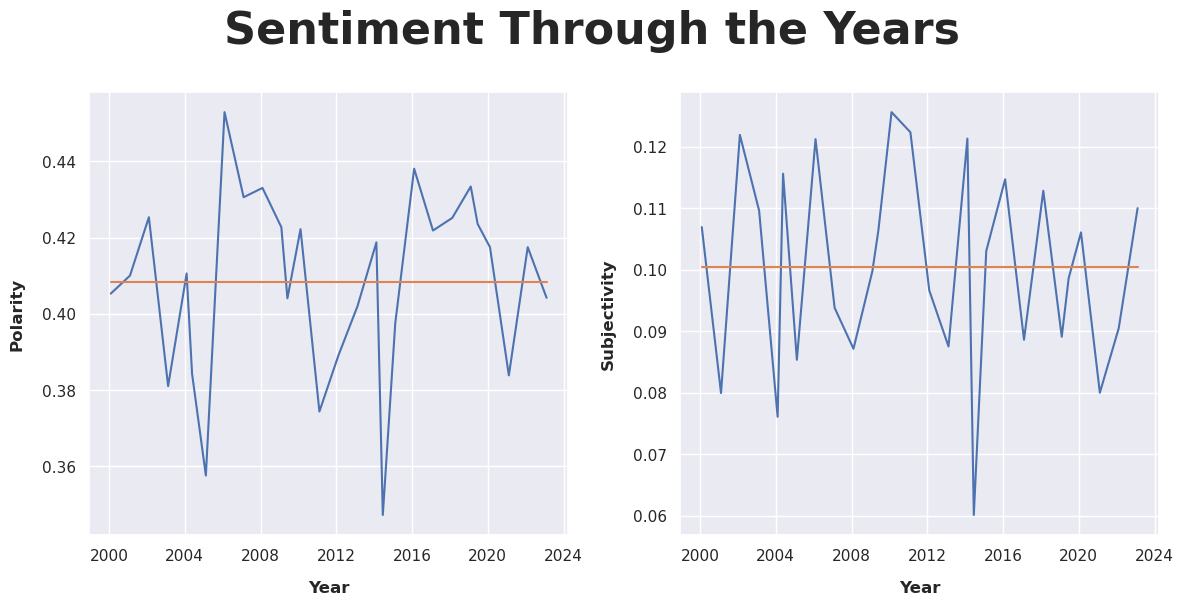

In [43]:
fig_03, _ = plt.subplots(nrows=1, ncols=2)


for index, sentiment in enumerate(["polarity", "subjectivity"], start=1):
    sns.lineplot(x=speeches.index, y=speeches[sentiment])
    sns.lineplot(x=speeches.index, y=np.mean(speeches[sentiment]))
    
    plt.subplot(1, 2, index)
    plt.xlabel("Year")
    plt.ylabel(sentiment.title())
    
    plt.tight_layout()

fig_03.suptitle(t="Sentiment Through the Years", y=1.006)

plt.tight_layout()
plt.show()


<br />

<h5 align="Center">Observations</h5>

<br />

<ul>
    <li><b><i>Polarity</i></b> looks to have averaged at about <b><i>0.41</i></b> with a deviation of roughly <b><i>0.04</i></b> over the years</li>
    <br />
    <li><b><i>Subjectivity</i></b> to looks to have a narrow range averaged at about <b><i>0.10</i></b> with a deviation of <b><i>0.02</i></b></li>
    <br />
    <li>Election years look to take a relatively major dip in <b><i>Polarity</i></b></li>
    <br />
    <li>Likewise, the 2014 elections look to have dropped <b><i>Subjectivity</i></b> by a milestone</li>
    <br />
    <li>Regardless, there looks to be minimal subjectivity throughout the years; I can only interpret this as being an alternative to presidents who are often reported as having an idyllic view of the country</li>
    
</ul>

<br />
<br />


<h1 align="Center">Conclusion</h1>

<br />
<br />


<p>Times have changed. The men at the helm of the country have changed. Yet, the state of the nation looks to have been stunted. As demonstrated by the word clouds, the primary focus has been on the <b><i>Government</i></b>, <b><i>People</i></b> and <b><i>Business</i></b>.</p>

<p>Even with the above principle concerns, even with the change in helmsmen, there looks to have been no increase in <b><i>Polarity</i></b>, perhaps the best way to get a sense of a president's outlook on the outcome of the outgoing year.</p>

<p>Lest we rush in with eyes full of anger and rage, consider that the state of the nation is not composed in isolation, but within the whirlwind that is the world economy. Add to that the increase in child survival rates, increased life spans, increased population and reduction in resources as a launchpad, and it does become easy to conceive of ideas as to the stunted <b><i>Polarity</i></b>.</p>

<br />
<br />
